# Import Libraries & Dependencies
 `opencv-python`: Data preprocessing

 `matplotlib`: Visualize preprocessed data
 
 `gdown`: Download dataset from Google Drive

 `imageio`: Create gifs from NumPy arrays

In [1]:
# %pip install opencv-python matplotlib tensorflow gdown imageio

In [86]:
import os
import numpy as np
import cv2 as cv
import tensorflow as tf
from matplotlib import pyplot as plt
import imageio
from typing import List

# Data-Loading

### 1. Download The Dataset
We"ll be using Nicholas Renotte"s lip-reading training dataset hosted on Google Drive.

Renotte"s dataset contains data from 1 speaker. It is derived from the GRID dataset (https://paperswithcode.com/dataset/grid) which contains data from over 30 speakers

In [11]:
dataset_name = "data"
if os.path.exists("data"):
    print("Data already downloaded.")
else:
    import gdown
    dataset_url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
    gdown.download(dataset_url, dataset_name, quiet=False)
    gdown.extractall(dataset_name)

Data already downloaded.


The downloaded dataset contains directories `s1` and `alignments`:

`s1`: Contains video clips of a person saying a series of words. The clips are in`.mpg` format.

`alignments`: Contains annotations for what is being said in the corresponding videos. The annotations are in `.align` format.

In [12]:
os.listdir("data")

['alignments', 's1']

### 2. Examine Video Clips

Let's visually inspect a few frames from a video clip before we preprocess the videos:

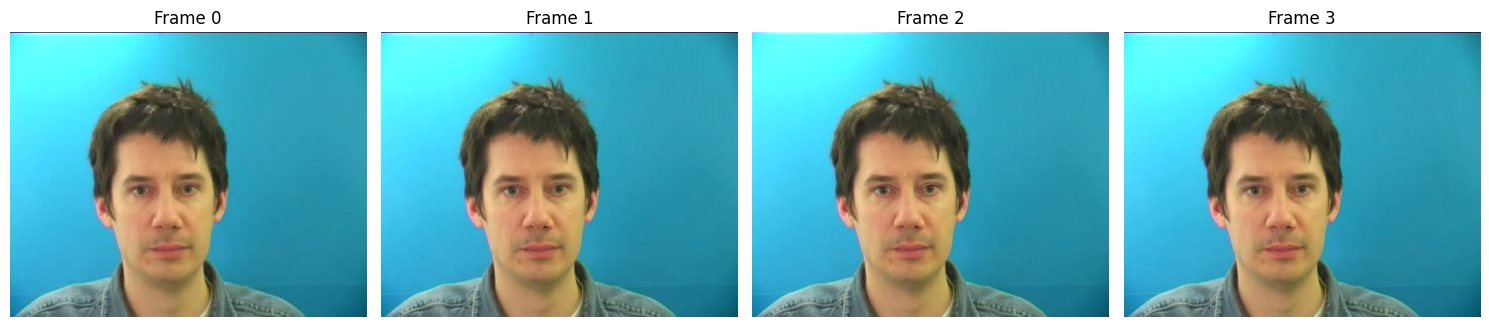

In [82]:
# Choose a video clip
video_file = os.path.join("data", "s1", "bbaf2n.mpg")   # s1 corresponds to Speaker 1

# Number of frames to visualize
num_frames = 4  

# VideoCapture object to read the video file
capture = cv.VideoCapture(video_file)

# List to hold video frames
frames_list = []

# Loop through video and extract frames
for frame in range(num_frames):
    _, frame = capture.read()

    # Convert the frame from BGR to RGB (OpenCV reads in BGR format)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    frames_list.append(frame)

capture.release()

fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

for i, frame in enumerate(frames_list):
    axes[i].imshow(frame)
    axes[i].set_title(f"Frame {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 3. Examine Annotations

Here are the contents of one of the `.align` annotation files:

In [14]:
annotation_example = os.path.join("data", "alignments", "s1", "bbaf2n.align")   # s1 corresponds to Speaker 1

with open(annotation_example, "r") as f:
    print(f.read())

0 23750 sil
23750 29500 bin
29500 34000 blue
34000 35500 at
35500 41000 f
41000 47250 two
47250 53000 now
53000 74500 sil



### 4. Define Our Vocabulary
The vocabulary is a list of characters we may encounter in the lip-read data.

Credit: **Automatic Speech Recognition using CTC** (https://keras.io/examples/audio/ctc_asr/#preprocessing)

In [15]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

The **Keras** `StringLookup` function can convert characters to numbers and vice versa.

In [16]:
# Mapping characters to integers
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

# Mapping integers back to characters
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size=40)


Now we can **tokenize** words, ie. a series of characters, into their corresponding numbers:

In [7]:
example_word = "chars"
char_to_num(list(example_word))

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 3,  8,  1, 18, 19], dtype=int64)>

And similarly **decode** numbers into characters:

In [17]:
num_to_char([ 3,  8,  1, 18, 19])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'c', b'h', b'a', b'r', b's'], dtype=object)>

### 5. Extract & Preprocess Video Frames
The LipNet paper used `DLib` to isolate the mouth/lip region of the speakers in the clips. We're going to be using **static slicing** to a similar effect.

In [18]:
# Function to load video frames
# Consumes: a data path to a video
# Produces: a list of floats representing that video
def load_video(path:str) -> List[float]: 
    capture = cv.VideoCapture(path)
    frames = [] # Stores video frames

    # Loop through video file frame-by-frame
    for _ in range(int(capture.get(cv.CAP_PROP_FRAME_COUNT))): 
        # Read video frame
        _, frame = capture.read()
        
        # Convert to grayscale to prevent large R,G,B values from unduly affecting the model
        frame = tf.image.rgb_to_grayscale(frame)
        
        # Extract and append mouth/lip region of frame
        frames.append(frame[190:236,80:220,:])
    capture.release()
    
    # Standardize/scale each frame and return list of frames
    mean = tf.math.reduce_mean(frames)
    standard_deviation = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / standard_deviation

### 6. Extract & Preprocess Alignments

Tokens are integer representations of characters in the alignments.

In [19]:
# Function to load alignments (annotations)
# Consumes: a data path to .align file
# Produces: a list of tokens (integers) corresponding to that .align file
def load_alignments(path:str) -> List[str]: 
    with open(path, "r") as f: 
        lines = f.readlines() 

    tokens = []
    for line in lines:
        line = line.split()

        if line[2] != "sil": # "sil" denotes silences, will be ignored 
            tokens = [*tokens, " ", line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), (-1)))[1:]

### 7. Load Video Frames & Alignments Simultaneously

In [25]:
# Consumes: a data path to a video
# Returns the preprocessed video frames and alignments together
def load_data(path: str):
    # .numpy() converts a tensor object into an numpy.ndarray object 
    path = bytes.decode(path.numpy())

    # Read in reverse ([-1]), and split on . to separate file name from extension
    file_name = path.split(os.path.sep)[-1].split(".")[0]

    video_path = os.path.join("data", "s1", f"{file_name}.mpg")
    alignment_path = os.path.join("data", "alignments", "s1", f"{file_name}.align")
    
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

### 8. Testing The Data-Loading Functions

Get a sample of video frames and its corresponding alignments:

In [26]:
test_video_path = os.path.join("data", "s1", "bbaf2n.mpg")
frames, alignments = load_data(tf.convert_to_tensor(test_video_path))

We've seen what the unprocessed video frames look like, now let's visualize some preprocessed frames.

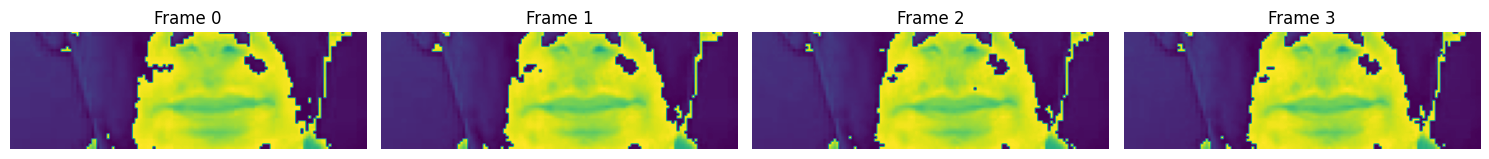

In [27]:
num_frames = 4
fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

for i, frame in enumerate(frames[:num_frames]):
    axes[i].imshow(frame)
    axes[i].set_title(f"Frame {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Examine the corresponding `alignments`:

In [28]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23], dtype=int64)>

We can decode the contents of `alignments` back into characters using `num_to_char()`:

In [29]:
# reduce_join() joins all strings into a single string
tf.strings.reduce_join(num_to_char(alignments))

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

### 9. Wrapper Function
Since we'd like to perform string operations (eg. using `split()`) on the tensor outputs of `load_data()`, we need to wrap them in `tf.py_function`:

In [30]:
# Function to wrap the output of load_data() in tf.py_function
def tf_py_function_map(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Building The Data Pipeline

### 1. Adjust Dimensions & Prefetch Data 

In [31]:
data_paths = tf.data.Dataset.list_files("data/s1/*.mpg") # Paths to the video clips
data_paths = data_paths.shuffle(404)
data = data_paths.map(tf_py_function_map)

The alignments are going to be of different lengths depending on the number of words in each `.align` file.

Therefore, we need to **pad** the `alignments` and so they all have **40** characters/tokens.

We will also make sure that each frames list has **75** frames.

In [32]:
# batch_size of 2 means each batch has 2 videos and 2 alignments
# "None" signifies that we're not padding the data of each frame
data = data.padded_batch(batch_size=2, padded_shapes=([75, None, None, None], [40]))

`prefetch()` is used to improve data loading performance by overlapping data loading and model execution. It prefetches a specified number of elements (usually batches) from the dataset.

In [33]:
prefetched_data = data.prefetch(tf.data.AUTOTUNE)   # Let TensorFlow decide batch size

### 2. Create Test/Train Split

In [34]:
video_clip_list = os.listdir(os.path.join("data", "s1"))
print(f"Total number of clips: {len(video_clip_list)}")

Total number of clips: 1001


In [35]:
train = prefetched_data.take(450)
test = prefetched_data.skip(450)

### 3. Test Data Pipeline Output

Get a new batch of `frames` and `alignments`:

In [36]:
test_data = test.as_numpy_iterator()

In [37]:
frames, alignments = test_data.next()

Verify the number of frame lists in `frames` and alignments in `alignments`:

In [40]:
print(f"Number of frame lists: {len(frames)}")
print(f"Number of alignments: {len(alignments)}")

Number of frame lists: 2
Number of alignments: 2


### 4. Visualizing Video Frames as a GIF

The Python library `imageio` can convert a NumPy array to a `.gif` file. This can be done using its `mimsave()` function that writes multiple images to a single file.

Let's use it to visualize some of our preprocessed video frames.

Since each `frames` batch has 2 video clips, the two frames lists are `frames[0]` and `frames[1]`.

In [41]:
frames[0].shape

(75, 46, 140, 1)

In [42]:
# Reshape the frames to (N, M), which represents grayscale images of dimensions NxM (46x140 here)
reshaped_frames = frames[0].reshape(-1, 46, 140)

# The frames are very dark because of the standardization we applied, let's brighten them
processed_frames = []
brightness_factor = 10

for frame in reshaped_frames:
    # Increase the brightness by multiplying the pixel values
    brightened_frame = frame * brightness_factor
    
    # Ensure pixel values are in the valid range (0-255)
    brightened_frame = np.clip(brightened_frame, 0, 255).astype(np.uint8)
    
    # Append the processed image to the list
    processed_frames.append(brightened_frame)

imageio.mimsave("images/test_output_animated.gif", processed_frames, duration=100) # duration in ms of each frame

The resulting GIF:

[<img src="images/test_output_animated.gif" width="300" loop=infinite/>]()

# Building The Neural Network

Since we're working with video data, we'll be designing a 3D Convolutional Neural Network (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

In [43]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

Some notes on the imported components:

`LSTM`: **L**ong **S**hort-**T**erm **M**emory. A type of recurrent neural network (RNN) architecture designed to capture and process sequences of data.

`Bidirectional LSTM`: Enhances the capabilities of traditional LSTM layers by processing input sequences in both forwards and backwards.
In speech recognition, phonemes at the beginning and end of a spoken word may affect each other, so Bidirectional LSTMs can better capture these dependencies.

`MaxPool3D`: Downsamples 3D data to reduce computational complexity while retaining essential features. Retains the maximum value within each region in the input data, keeping the most prominent features detected by the previous convolutional layers.

### Model Schematic
A diagram of the LipNet model architecture (https://arxiv.org/abs/1611.01599):

[<img src="images/LipNet_diagram.jpg" width="700"/>]()

In [44]:
model = Sequential()

# The input is an array of 75 46x140 images
model.add(Conv3D(filters=128, kernel_size=3,
                 input_shape=(75,46,140,1),
                 padding='same',
                 activation='relu'))    # ReLU activation to add non-linearity

# Downsamples height and width of the data by a factor of 2
model.add(MaxPool3D(pool_size=(1,2,2)))   # (depth, height, width)

model.add(Conv3D(filters=256,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))

model.add(MaxPool3D(pool_size=(1,2,2)))

# 75 inputs into LSTMs, corresponding to 75 video frames
model.add(Conv3D(filters=75,
                 kernel_size=3,
                 padding='same',
                 activation='relu'))

model.add(MaxPool3D(pool_size=(1,2,2)))

# Apply Flatten() to each time-step to prepare for sequence processing
model.add(TimeDistributed(Flatten()))

# return_sequences=True so that the LSTM returns entire sequence instead of a single unit
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# Dropout to reduce overfitting, rate of 0.5 specified in the paper
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

# Num of units in the Dense layer = vocabulary size + 1 (the softmax output)
model.add(Dense(units=(char_to_num.vocabulary_size()+1),
                kernel_initializer='he_normal',
                activation='softmax'))  # softmax activation to return the most likely character

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 75, 11, 35, 75)    518475    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 75, 5, 17, 75)    0

# Setup Training Options & Train

### 1. Connectionist Temporal Classification (CTC) Loss
CTC is a loss function widely used in modern speech recognition as it eliminates the need for training data that aligns inputs to target outputs.

In [47]:
# Source: https://keras.io/examples/audio/ctc_asr/#model

def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")  # 75, the num of frames
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")  # 40, the num of characters

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # Not a lot of documentation available for this function
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

### 2. Callbacks

Callback function to adjust the learning rate while training:

In [46]:
def learning_rate_scheduler(epoch, learning_rate):
    if epoch < 30:
        return learning_rate
    else:
        # Exponentially reduce learning_rate after 30 epochs
        return learning_rate * tf.math.exp(-0.1)

Subclassed Callback function. It will make a prediction and compare it to the original at the end of each epoch:

In [49]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

Now that we have written the loss and the callback function, compile the model:

In [50]:
# Learning rate of 10**-4 from the paper
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

Callback to save model weights at each checkpoint:

In [51]:
checkpoint_callback = ModelCheckpoint(os.path.join("models","checkpoint"), monitor='loss', save_weights_only=True)

Callback to adjust learning rate at each epoch after 30 epochs:

In [52]:
schedule_callback = LearningRateScheduler(learning_rate_scheduler)

Callback to make predictions after each epoch:

In [53]:
example_callback = ProduceExample(test)

### 3. Train The Model

100 epochs took well over 11 hours of training on a RTX 2060 6 GB graphics card.

In [35]:
model.fit(x=train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
1/1 [==============================] - 2s 2s/steps - loss: 84.39
Original: bin green with i zero please
Prediction: le e e e e n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue at p one again
Prediction: le e e e n o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 772s 2s/step - loss: 84.3946 - val_loss: 68.6074 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 0s 154ms/step loss: 70.15
Original: lay blue by e two please
Prediction: la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place blue by p four please
Prediction: la e e e eo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 546s 1s/step - loss: 70.1560 - val_loss: 64

KeyboardInterrupt: 

# Making Predictions

### 1. Load Saved Model Weights

In [54]:
model.load_weights("models/checkpoint")

### 2. Testing On Preprocessed Video Frames
We'll first test the model with data similar to what it was trained on. Get a data sample from the pipeline:

In [55]:
test_data = test.as_numpy_iterator()

In [56]:
sample = test_data.next()

`sample[0]` holds 2 video frame arrays, `sample[1]` holds their annotations/alignments:

In [61]:
print(f"sample[0] holds 2 arrays 75 46x140 video frames: {sample[0].shape}")
print(f"sample[1] holds 2 alignments of length 40 each: {sample[1].shape}")

sample[0] holds 2 arrays 75 46x140 video frames: (2, 75, 46, 140, 1)
sample[1] holds 2 alignments of length 40 each: (2, 40)


Making predictions on the 2 video frame arrays:

In [62]:
predictions = model.predict(sample[0])

1/1 [==============================] - 4s 4s/step


Decode the predictions like we did in the `ProduceExample()` callback:

In [65]:
decoded_predictions = tf.keras.backend.ctc_decode(predictions, input_length=[75,75], greedy=True)[0][0].numpy()

Compare the original alignment to the prediction:

In [69]:
for original, prediction in zip(sample[1], decoded_predictions):
    print('Original:', tf.strings.reduce_join(num_to_char(original)).numpy().decode('utf-8'))
    print('Prediction:', tf.strings.reduce_join(num_to_char(prediction)).numpy().decode('utf-8'))
    print('~'*100)

Original: set green with d two please
Prediction: set green with d two please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white by s three again
Prediction: lay white by s three again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


The model made the predictions correctly!

### 3. Testing On Unpreprocessed Videos
The model performs well on preprocessed video data. Next, we'll test it on non-pipeline, unprocessed video clips.

In [70]:
test_unprocessed_video = os.path.join("data", "s1", "swwv9a.mpg")
unprocessed_video_frames, alignment = load_data(tf.convert_to_tensor(test_unprocessed_video))

Expand the frame list's dimensions to match the (1, 75, 46, 140, 1) shape that the model expects, and make a prediction:

In [77]:
prediction = model.predict(tf.expand_dims(unprocessed_video_frames, axis=0))

1/1 [==============================] - 1s 763ms/step


Decode the prediction:

In [80]:
decoded_prediction = tf.keras.backend.ctc_decode(prediction, input_length=[75], greedy=True)[0][0].numpy()

Compare the decoded prediction to the original alignment:

In [81]:
print('Original:', tf.strings.reduce_join(num_to_char(alignment)).numpy().decode('utf-8'))
print('Prediction:', tf.strings.reduce_join(num_to_char(decoded_prediction)).numpy().decode('utf-8'))
print('~'*100)

Original: set white with sp v nine again
Prediction: set white with sp s nine again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


The model predicted correctly even with an unprocessed video clip.

# Conclusion
We successfully implemented a deep neural network based on the **LipNet** architecture capable of NLP through lip-reading. Once the model was trained, we tested it on both preprocessed and unprocessed video data, demonstrating its ability to accurately predict spoken words from lip movements.

### Future Work
- Training the model was a computationally intensive task taking over 11 hours on an RTX 2060 6 GB graphics card. I would like to explore ways of speeding up training without significantly sacrificing model prediction accuracy.

- A lip-reading app can have a positive impact on accessibility, something that I have been working towards improving since my early American Sign Language character classification models. I would like to deploy the enhanced capabilities of this 3D convolution model using an app framework such as **Flask** or **StreamLit**.